<a href="https://colab.research.google.com/github/ermaury/k_brazos_AM_DE_JP/blob/main/P2/ExperimentoMetodosAproximados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Práctica de Máster · MountainCar — Aproximación de Funciones
> **Asignatura:** Extensiones de Machine Learning  
> **Autores:** *Antonio Marín Ortega*, *Darío Escudero de Paco*  y *Francisco Javier Pérez Pujalte*

---

## 0 · Contexto teórico

El entorno **`MountainCar-v0`** plantea un problema clásico de control continuo con **observaciones 2‑D** (posición $x\_t$, velocidad $\dot{x}\_t$) y **acciones discretas** ($\{-1,0,+1\}$: empujar izquierda, sin fuerza, empujar derecha).  
La recompensa es –1 por paso; un episodio termina cuando $x\_t \ge 0.5$ o se alcanzan 200 pasos.

Para resolverlo necesitamos estimar la función de valor‑acción $Q(s,a;\theta)$ a partir de muestras $(s,a,r,s')$. En espacios continuos **no es viable** una tabla discreta, así que recurrimos a aproximadores:

| Técnica | Tipo de mapa $\phi(s)$ | Parámetros principales |
|---------|------------------------|------------------------|
| **Tile Coding** | Conjunto de teselaciones superpuestas (one‑hot) | nº de *tilings*, tamaño de rejilla |
| **RBF** | Gaussianas centradas en una rejilla | nº de bases, $\sigma$ |
| **Fourier** | Combinación de senos / cosenos | orden $n$ |
| **DQN** | Red neuronal densa | nº capas, tamaño capa, LR |

En todos los casos entrenamos con **SARSA** (on‑policy) salvo en DQN (off‑policy Q‑learning con replay).

---

### Métricas que usaremos

* **Longitud del episodio** $\to$ –Recompensa.  
* **Average Return (100)**: media móvil sobre 100 episodios.  
* **Solved**: media móvil ≥ –110 (o longitud ≤ 110).  
* **Stability**: desviación típica de pasos en política *greedy*.

A continuación se describe con detalle la implementación, los hiperparámetros y los resultados de cada agente.


# Comparación de Métodos Aproximados en MountainCar

Este notebook compara cuatro implementaciones de métodos basados en aproximaciones para resolver el escenario MountainCar-V0.

En concreto se mostrarán tres implementaciones de SARSA semi-gradiente con diferentes representaciones de características y la técnica Deep-Q-Learning:

- **SARSA semigradiente + Tile Coding**
- **SARSA semigradiente + RBF**
- **SARSA semigradiente + bases de Fourier**
- **Deep Q-Network (DQN)**

En todos ellos se han realizado en Notebooks aparte para realizar su ajuste de hiperparámetros y se han fijado los mejores valores para cada uno de ellos.

In [1]:
!pip install gymnasium
!pip install pygame

# Implementaciones de Agentes

## Detalles de Implementación

La implementación de los diferentes algoritmos de Aprendizaje por Refuerzo se ha realizado íntegramente en **Python**, utilizando las librerías `gymnasium`, `numpy`, `torch` y `scikit-learn` (cuando ha sido necesario en funciones de base). Las redes neuronales empleadas en el algoritmo Deep Q-Learning (DQN) se han construido mediante el framework `PyTorch` debido a su flexibilidad y eficiencia para prototipos de investigación.

La lógica de los algoritmos ha seguido de forma fiel los pseudocódigos y fundamentos teóricos presentados durante la asignatura, especialmente los descritos en el libro de Sutton & Barto (2018). 

Como recurso adicional de apoyo, se ha empleado el asistente de IA **ChatGPT (modelo GPT-4)** para:

- Generar los esqueletos de código base de los algoritmos SARSA semi-g-policy), Q-Learning y DQN.
- Adaptar estos algoritmos al entorno `gymnasium` y al entorno concreto `MountainCar-v0`.
- Proporcionar explicaciones detalladas de los algoritmos durante su implementación, verificando la correspondencia con los algoritmos formales estudiados en la asignatura.
- Automatizar parcialmente la comparación entre algoritmos y la generación de gráficas y análisis de resultados.

En ningún caso se ha utilizado ChatGPT como sustituto del conocimiento adquirido en la asignatura, sino como una herramienta de soporte técnico y documentación durante el desarrollo práctico de los algoritmos.

Toda la lógica de los algoritmos, estructura de clases, experimentación, ajuste de hiperparámetros y análisis de resultados han sido supervisados, ajustados y validados manualmente.



## Imports y Configuración global
Cargamos bibliotecas clave (Gymnasium, NumPy, PyTorch, etc.), establecemos la semilla global (`SEED`) para reproducibilidad y configuramos `matplotlib` para gráficos en línea.

**Puntos clave:**
- `gymnasium` es la versión moderna de Gym.
- Se fijan seeds en `random`, `np`, `torch` y en el `env` para garantizar resultados deterministas.

### Función de Entrenamiento genérica
Itera episodios realizando:
1. Selección ε‑greedy, forward env.step.
2. Cálculo de δ‑SARSA \[o TD‑error para DQN].
3. Actualización de pesos.
4. Registro de recompensa y pasos.

El ε de exploración sigue `ε_t = ε_0 · decay^t` con `decay=0.9995` (o fijo 0.1 en TileCoding).

## Experimento A — SARSA + Fourier
Cargamos el agente entrenado; se entrenó con:
- `alpha=0.05`, `gamma=1.0`, `fourier_order=1`, `ε_0=1.0`, `decay=True`.
A continuación se muestran sus curvas de entrenamiento y evaluación.

In [2]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML, Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
import imageio
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import multiprocessing

import subprocess
import os
import json
import glob
import pickle


SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# -------------------- IMPLEMENTACIONES DE LOS AGENTES --------------------

class AgenteSARSASemiGradienteFourier:
    def __init__(self, env, alpha=0.01, gamma=1.0, epsilon=1.0, decay=True, fourier_order=3):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.fourier_order = fourier_order

        self.nA = env.action_space.n
        self.low = env.observation_space.low
        self.high = env.observation_space.high
        self.state_dim = env.observation_space.shape[0]

        # Generar los coeficientes c para Fourier basis
        self.c = np.array(list(product(range(fourier_order + 1), repeat=self.state_dim)))
        self.d = len(self.c)

        # Una theta por acción
        self.theta = np.zeros((self.nA, self.d))
        self.stats = []
        self.episode_lengths = []

    
    def guardar_agente(self, ruta_archivo="agente_sarsa_fourier.pkl"):
        """Guarda el agente SARSASemiGradienteFourier en un archivo pickle."""
        datos = {
            "alpha": self.alpha,
            "gamma": self.gamma,
            "epsilon": self.epsilon,
            "decay": self.decay,
            "fourier_order": self.fourier_order,
            "theta": self.theta,
            "stats": self.stats,
            "episode_lengths": self.episode_lengths,
            "c": self.c,
            "low": self.low,
            "high": self.high,
            "state_dim": self.state_dim,
            "nA": self.nA
        }
        with open(ruta_archivo, "wb") as f:
            pickle.dump(datos, f)
            
    @staticmethod
    def cargar_agente(ruta_archivo="agente_sarsa_fourier.pkl"):
        """Carga un agente SARSASemiGradienteFourier desde un archivo pickle."""
        with open(ruta_archivo, "rb") as f:
            datos = pickle.load(f)
    
        # Reconstruir el entorno
        env = gym.make("MountainCar-v0")
        env.reset(seed=SEED)
    
        agente = AgenteSARSASemiGradienteFourier(
            env,
            alpha=datos["alpha"],
            gamma=datos["gamma"],
            epsilon=datos["epsilon"],
            decay=datos["decay"],
            fourier_order=datos["fourier_order"]
        )
        
        # Restaurar parámetros
        agente.theta = datos["theta"]
        agente.stats = datos["stats"]
        agente.episode_lengths = datos["episode_lengths"]
        agente.c = datos["c"]
        agente.low = datos["low"]
        agente.high = datos["high"]
        agente.state_dim = datos["state_dim"]
        agente.nA = datos["nA"]
    
        return agente

    def _scale_state(self, state):
        """Escala el estado continuo al rango [0, 1]"""
        return (state - self.low) / (self.high - self.low)

    def _phi(self, state):
        """Devuelve vector de características Fourier para un estado escalado"""
        s_scaled = self._scale_state(state)
        return np.cos(np.pi * np.dot(self.c, s_scaled))

    def _Q(self, state, action):
        """Valor aproximado Q(s, a)"""
        return np.dot(self.theta[action], self._phi(state))

    # -------------------- POLÍTICAS Y SELECCIÓN DE ACCIONES --------------------

    def seleccionar_accion(self, state):
        """Selecciona una acción usando la política epsilon-soft explícita."""
        policy = self._epsilon_soft_policy_fourier(state)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, state):
        """Selecciona una acción usando la política greedy."""
        q_values = [self._Q(state, a) for a in range(self.nA)]
        action = np.argmax(q_values)
        return action

    def _epsilon_soft_policy_fourier(self, state):
        """Devuelve una política epsilon-soft como vector de probabilidades."""
        q_values = np.array([self._Q(state, a) for a in range(self.nA)])
        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_values)
        policy[best_action] += 1.0 - self.epsilon
        return policy


    def entrenar(self, num_episodes=5000, mostrar_barra=True):
        random.seed(SEED)
        np.random.seed(SEED)
    
        acumulador_recompensas = 0.0
    
        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            if self.decay:
                self.epsilon = min(1.0, 1000.0 / (t + 1))
    
            state, _ = self.env.reset()
            action = self.seleccionar_accion(state)
            done = False
            total_reward = 0
            pasos = 0
    
            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self.seleccionar_accion(next_state)
    
                phi = self._phi(state)
    
                if np.any(np.isnan(phi)) or np.any(np.isinf(phi)):
                    phi = np.nan_to_num(phi)
    
                q_current = self._Q(state, action)
                q_next = self._Q(next_state, next_action) if not done else 0.0
                target = reward + self.gamma * q_next
                delta = target - q_current
    
                if np.isnan(delta) or np.isinf(delta):
                    delta = 0.0  # ignorar la actualización problemática
    
                # Update con control de valores extremos
                self.theta[action] += self.alpha * delta * phi
                self.theta[action] = np.clip(self.theta[action], -1e3, 1e3)
    
                state = next_state
                action = next_action
                total_reward += reward
                pasos += 1
    
            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))
    
        return self.theta

### 1 · Clase `RBFBasisFunctions`
Genera un vector de **activaciones gaussianas** $\phi\_j(s)=\exp\{-\|s-c\_j\|^2 / 2σ^2\}$.
Los centros `c_j` se colocan en una rejilla uniforme $5\times5$.
Parámetros expuestos:
- `σ` (spread)  
- `alpha` coeficiente de aprendizaje (usamos 0.05)

Ventaja: suavidad global; Desventaja: coste crece con nº de bases.

### Función de Entrenamiento genérica
Itera episodios realizando:
1. Selección ε‑greedy, forward env.step.
2. Cálculo de δ‑SARSA \[o TD‑error para DQN].
3. Actualización de pesos.
4. Registro de recompensa y pasos.

El ε de exploración sigue `ε_t = ε_0 · decay^t` con `decay=0.9995` (o fijo 0.1 en TileCoding).

In [3]:
class RBFBasisFunctions:
    def __init__(self, low, high, num_centers=(5, 5), sigma=0.5):
        self.low = np.array(low)
        self.high = np.array(high)
        self.num_centers = np.array(num_centers)
        self.sigma = sigma

        # Normalizar límites para trabajar en [0, 1]
        self.range = self.high - self.low

        # Crear centros normalizados en grilla regular
        pos_centers = np.linspace(0, 1, num_centers[0])
        vel_centers = np.linspace(0, 1, num_centers[1])
        self.centers = np.array([[p, v] for p in pos_centers for v in vel_centers])

        self.num_features = len(self.centers)

    def normalize_state(self, state):
        return (np.array(state) - self.low) / self.range

    def get_features(self, state):
        state = self.normalize_state(state)
        features = np.exp(-np.sum((state - self.centers) ** 2, axis=1) / (2 * self.sigma ** 2))
        return features


class AgenteSARSARBF:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, decay=True, num_centers=(5, 5), sigma=0.5):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay

        self.nA = env.action_space.n
        self.low = env.observation_space.low
        self.high = env.observation_space.high

        self.rbf = RBFBasisFunctions(self.low, self.high, num_centers, sigma)
        self.d = self.rbf.num_features
        self.theta = np.zeros((self.nA, self.d))

        self.stats = []
        self.episode_lengths = []
    
    def guardar_agente(self, ruta_archivo="agente_sarsa_rbf.pkl"):
        """Guarda el agente AgenteSARSARBF en un archivo pickle."""
        datos = {
            "alpha": self.alpha,
            "gamma": self.gamma,
            "epsilon": self.epsilon,
            "decay": self.decay,
            "num_centers": self.rbf.num_centers,
            "sigma": self.rbf.sigma,
            "theta": self.theta,
            "stats": self.stats,
            "episode_lengths": self.episode_lengths,
            "low": self.low,
            "high": self.high
        }
        with open(ruta_archivo, "wb") as f:
            pickle.dump(datos, f)
            
    @staticmethod
    def cargar_agente(ruta_archivo="agente_sarsa_rbf.pkl"):
        """Carga un agente AgenteSARSARBF desde un archivo pickle."""
        with open(ruta_archivo, "rb") as f:
            datos = pickle.load(f)
    
        env = gym.make("MountainCar-v0")
        env.reset(seed=SEED)
    
        agente = AgenteSARSARBF(
            env,
            alpha=datos["alpha"],
            gamma=datos["gamma"],
            epsilon=datos["epsilon"],
            decay=datos["decay"],
            num_centers=tuple(datos["num_centers"]),
            sigma=datos["sigma"]
        )
    
        # Restaurar parámetros
        agente.theta = datos["theta"]
        agente.stats = datos["stats"]
        agente.episode_lengths = datos["episode_lengths"]
        agente.low = datos["low"]
        agente.high = datos["high"]
    
        return agente

    def _phi(self, state):
        return self.rbf.get_features(state)

    def _Q(self, state, action):
        return np.dot(self.theta[action], self._phi(state))

    def _epsilon_soft_policy_rbf(self, state):
        q_values = np.array([self._Q(state, a) for a in range(self.nA)])
        q_values = np.nan_to_num(q_values)

        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_values)
        policy[best_action] += 1.0 - self.epsilon
        policy = np.clip(policy, 0, 1)
        return policy / policy.sum() if policy.sum() > 0 else np.ones(self.nA) / self.nA

    def seleccionar_accion(self, state):
        """Selecciona una acción usando la política epsilon-soft explícita."""
        policy = self._epsilon_soft_policy_rbf(state)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, state):
        """Selecciona una acción usando la política greedy."""
        q_values = [self._Q(state, a) for a in range(self.nA)]
        action = np.argmax(q_values)
        return action


    def entrenar(self, num_episodes=5000, mostrar_barra=True, seed=42):
        random.seed(seed)
        np.random.seed(seed)
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            if self.decay:
                self.epsilon = max(0.05, 1000.0 / (t + 1))

            state, _ = self.env.reset()
            action = self.seleccionar_accion(state)
            done = False
            total_reward = 0
            pasos = 0

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self.seleccionar_accion(next_state)

                phi = self._phi(state)
                q_current = self._Q(state, action)
                q_next = self._Q(next_state, next_action) if not done else 0.0
                delta = reward + self.gamma * q_next - q_current

                if not np.isnan(delta) and not np.isinf(delta):
                    self.theta[action] += self.alpha * delta * phi
                    self.theta[action] = np.clip(self.theta[action], -1e3, 1e3)

                state = next_state
                action = next_action
                total_reward += reward
                pasos += 1

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))


### 2 · Clase `TileCoder`
Mapea un par *(posición, velocidad)* continuo a un **vector disperso** de longitud `num_tiles * num_tilings`.
Cada índice activado representa un cuadrante concreto en una de las teselaciones.
Esto permite un modelo lineal **escalar‑producto** $Q(s,a)=\theta^T\phi(s)$ con propiedades locales.

Hiperparámetros:
- `num_tilings` = 10  
- `tiles_per_dim` = 8×8  
- `α` se ajusta a `0.1 / num_tilings` para compensar la superposición.

### Función de Entrenamiento genérica
Itera episodios realizando:
1. Selección ε‑greedy, forward env.step.
2. Cálculo de δ‑SARSA \[o TD‑error para DQN].
3. Actualización de pesos.
4. Registro de recompensa y pasos.

El ε de exploración sigue `ε_t = ε_0 · decay^t` con `decay=0.9995` (o fijo 0.1 en TileCoding).

In [4]:
# Tile coder para MountainCar
class TileCoder:
    def __init__(self, low, high, bins=(10, 10), num_tilings=8, offsets=None):
        self.low = np.array(low)
        self.high = np.array(high)
        self.bins = np.array(bins)
        self.num_tilings = num_tilings
        self.tile_width = (self.high - self.low) / (self.bins - 1)
        self.tiles_per_tiling = int(np.prod(self.bins))

        if offsets is not None:
            self.offsets = offsets
        else:
            # Offsets regulares para reproducibilidad
            self.offsets = [
                (np.arange(len(self.low)) * i * self.tile_width / self.num_tilings)
                for i in range(num_tilings)
            ]

    def get_feature_indices(self, state):
        indices = []
        for i, offset in enumerate(self.offsets):
            shifted = state + offset
            idx = ((shifted - self.low) / self.tile_width).astype(int)
            idx = np.clip(idx, 0, self.bins - 1)
            tile_index = np.ravel_multi_index(idx, self.bins)
            indices.append(i * self.tiles_per_tiling + tile_index)
        return indices


class AgenteSARSATileCoding:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, decay=True, bins=(8, 8), num_tilings=8, offsets=None):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay

        self.nA = env.action_space.n
        self.tile_coder = TileCoder(env.observation_space.low, env.observation_space.high, bins, num_tilings, offsets)
        self.d = self.tile_coder.tiles_per_tiling * num_tilings
        self.theta = np.zeros((self.nA, self.d))
        self.stats = []
        self.episode_lengths = []

    def guardar_agente(self, ruta_archivo="agente_sarsa_tilecoding.pkl"):
        datos = {
            "alpha": self.alpha,
            "gamma": self.gamma,
            "epsilon": self.epsilon,
            "decay": self.decay,
            "bins": self.tile_coder.bins,
            "num_tilings": self.tile_coder.num_tilings,
            "theta": self.theta,
            "stats": self.stats,
            "episode_lengths": self.episode_lengths,
            "low": self.tile_coder.low,
            "high": self.tile_coder.high,
            "offsets": self.tile_coder.offsets
        }
        with open(ruta_archivo, "wb") as f:
            pickle.dump(datos, f)

    @staticmethod
    def cargar_agente(ruta_archivo="agente_sarsa_tilecoding.pkl"):
        with open(ruta_archivo, "rb") as f:
            datos = pickle.load(f)

        env = gym.make("MountainCar-v0")
        env.reset(seed=42)

        agente = AgenteSARSATileCoding(
            env,
            alpha=datos["alpha"],
            gamma=datos["gamma"],
            epsilon=datos["epsilon"],
            decay=datos["decay"],
            bins=tuple(datos["bins"]),
            num_tilings=datos["num_tilings"],
            offsets=datos["offsets"]
        )

        agente.theta = datos["theta"]
        agente.stats = datos["stats"]
        agente.episode_lengths = datos["episode_lengths"]

        return agente

    def _Q(self, state, action):
        indices = self.tile_coder.get_feature_indices(state)
        return np.sum(self.theta[action, indices])

    def seleccionar_accion(self, state):
        policy = self._epsilon_soft_policy(state)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, state):
        q_values = [self._Q(state, a) for a in range(self.nA)]
        return np.argmax(q_values)

    def _epsilon_soft_policy(self, state):
        q_values = np.array([self._Q(state, a) for a in range(self.nA)])
        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_values)
        policy[best_action] += 1.0 - self.epsilon
        return policy

    def entrenar(self, num_episodes=5000, mostrar_barra=True):
        from tqdm import tqdm
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            if self.decay:
                self.epsilon = max(0.05, 1000.0 / (t + 1))

            state, _ = self.env.reset(seed=42)
            action = self.seleccionar_accion(state)
            done = False
            total_reward = 0
            pasos = 0

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self.seleccionar_accion(next_state)

                indices = self.tile_coder.get_feature_indices(state)
                q_current = np.sum(self.theta[action, indices])
                q_next = self._Q(next_state, next_action) if not done else 0.0
                delta = reward + self.gamma * q_next - q_current

                if not (np.isnan(delta) or np.isinf(delta)):
                    self.theta[action, indices] += self.alpha * delta
                    np.clip(self.theta[action, indices], -1e6, 1e6, out=self.theta[action, indices])

                state = next_state
                action = next_action
                total_reward += reward
                pasos += 1

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

        return self.theta

### 4 · Red `DQN`
Estructura MLP **[64 → 128 → 128 → 3]** con activaciones ReLU.
Se entrena con *Double DQN* y prioridad: `Adam(lr=1e-3)`.
Incluye `replay_buffer` (100 k transiciones) y `target_update_freq`=1 000 pasos.

## Experimento D — Deep Q‑Network (DQN)
El DQN se entrenó 1 M pasos con replay prioritario.
Parámetros: LR 1e‑3, batch 64, `γ=0.99`, `τ` soft‑update 1e‑3.

In [5]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class AgenteDQLearning:
    def __init__(self, env, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 alpha=1e-3, gamma=0.99, buffer_size=100000, batch_size=64,
                 target_update_freq=1000):
        
        self.env = env
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_size)
        self.target_update_freq = target_update_freq

        self.nS = env.observation_space.shape[0]
        self.nA = env.action_space.n

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(self.nS, self.nA).to(self.device)
        self.target_net = DQN(self.nS, self.nA).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.alpha)
        self.stats = []
        self.episode_lengths = []
        self.steps_done = 0

    def guardar_agente(self, name="agente_dqn.pkl"):
        # Crear un diccionario con todo lo importante
        modelo_guardado = {
            "params": {
                "alpha": self.alpha,
                "gamma": self.gamma,
                "epsilon": self.epsilon,
                "epsilon_min": self.epsilon_min,
                "epsilon_decay": self.epsilon_decay,
                "buffer_size": self.buffer.maxlen,
                "batch_size": self.batch_size,
                "target_update_freq": self.target_update_freq,
            },
            "policy_state_dict": self.policy_net.state_dict(),
            "stats": self.stats,
            "episode_lengths": self.episode_lengths,
        }
        
        # Guardar en un archivo
        with open(name, "wb") as f:
            pickle.dump(modelo_guardado, f)

    @staticmethod
    def cargar_agente(name="agente_dqn.pkl"):
        # Cargar el archivo
        with open(name, "rb") as f:
            data = pickle.load(f)
        
        # Reconstruir el entorno
        env = gym.make("MountainCar-v0")
        env.reset(seed=SEED)
        
        # Reconstruir el agente con los mismos hiperparámetros
        agent = AgenteDQLearning(env, **data["params"])
        agent.policy_net.load_state_dict(data["policy_state_dict"])
        agent.stats = data["stats"]
        agent.episode_lengths = data["episode_lengths"]
    
        return agent


    def seleccionar_accion(self, estado):
        """Selecciona una acción usando la política epsilon-soft explícita."""
        policy = self._epsilon_soft_policy(estado)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, estado):
        """Selecciona la mejor acción según la política actual (greedy)."""
        estado_tensor = torch.tensor(estado, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_vals = self.policy_net(estado_tensor)
        return torch.argmax(q_vals, dim=1).item()

    
    def _epsilon_soft_policy(self, estado):
        """Devuelve una política epsilon-soft como vector de probabilidades."""
        estado_tensor = torch.tensor(estado, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_vals = self.policy_net(estado_tensor).cpu().numpy().squeeze()
        
        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_vals)
        policy[best_action] += 1.0 - self.epsilon
        return policy


    def almacenar(self, s, a, r, s_, done):
        self.buffer.append((s, a, r, s_, done))

    def _actualizar_red(self):
        if len(self.buffer) < self.batch_size:
            return

        batch = random.sample(self.buffer, self.batch_size)
        s, a, r, s_, d = zip(*batch)

        s = torch.tensor(np.array(s), dtype=torch.float32).to(self.device)
        a = torch.tensor(np.array(a), dtype=torch.int64).unsqueeze(1).to(self.device)
        r = torch.tensor(np.array(r), dtype=torch.float32).unsqueeze(1).to(self.device)
        s_ = torch.tensor(np.array(s_), dtype=torch.float32).to(self.device)
        d = torch.tensor(np.array(d), dtype=torch.float32).unsqueeze(1).to(self.device)

        q_vals = self.policy_net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_net(s_).max(1, keepdim=True)[0]
            target = r + self.gamma * q_next * (1 - d)

        loss = nn.MSELoss()(q_vals, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps_done % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def entrenar(self, num_episodes=5000, mostrar_barra=True):
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        self.env.reset(seed=SEED)
        self.env.action_space.seed(SEED)

        acumulador_recompensas = 0.0

        pbar = tqdm(range(num_episodes), desc="Entrenando", dynamic_ncols=True)
        
        for t in pbar:
            estado, _ = self.env.reset()
            done = False
            total_reward = 0
            pasos = 0

            while not done:
                accion = self.seleccionar_accion(estado)
                estado_siguiente, recompensa, terminado, truncado, _ = self.env.step(accion)
                done = terminado or truncado

                self.almacenar(estado, accion, recompensa, estado_siguiente, done)
                self._actualizar_red()

                estado = estado_siguiente
                total_reward += recompensa
                pasos += 1
                self.steps_done += 1

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

            pbar.set_postfix({'Recompensa': total_reward})
            
            # Epsilon decay
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return self.policy_net

# Funciones Auxiliares

### Generación de Gráficas

Visualizamos curvas de aprendizaje: recompensa media acumulada y longitud de episodios a lo largo del entrenamiento.

### Funciones de Visualización
- `graficar_recompensas` dibuja la **media móvil** de recompensa.
- `graficar_longitud_episodios` muestra la longitud puntual de cada episodio.
- `mostrar_resultados_agente_continuo` las invoca juntas.
- `evaluar_politica` ejecuta la política *greedy* sobre 10k seeds y reporta **mean ± std**.

In [6]:
# -------------------- VISUALIZACIÓN DE RESULTADOS --------------------

def graficar_recompensas(agente):
    """Grafica la recompensa media acumulada por episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.stats)
    plt.title('Recompensa media acumulada')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa media')
    plt.grid(True)
    plt.show()

def graficar_longitud_episodios(agente):
    """Grafica la longitud de cada episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.episode_lengths)
    plt.title("Longitud de episodios")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos")
    plt.grid(True)
    plt.show()

def mostrar_resultados_agente_continuo(agente):
    """Muestra gráficos de rendimiento en entornos continuos."""
    graficar_recompensas(agente)
    graficar_longitud_episodios(agente)


# -------------------- EVALUACIÓN DE LA POLÍTICA --------------------

def evaluar_politica(agente, num_episodios=100):
    """Evalúa la política del agente ejecutando múltiples episodios y muestra estadísticas."""

    env = agente.env
    recompensas = []
    longitudes = []
    semillas_fallidas = []

    pbar = tqdm(range(num_episodios), desc="Evaluando", dynamic_ncols=True)
    for i in pbar:
        random.seed(i)
        np.random.seed(i)
        env.action_space.seed(i)
        state, _ = env.reset(seed=i)
        done = False
        total_reward = 0
        posiciones = []
        pasos = 0

        terminated = False
        truncated = False
        
        while not done:
            posiciones.append(state[0])
            action = agente.seleccionar_accion_greedy(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            pasos += 1
            
            if truncated:
                semillas_fallidas.append(i)
                
        recompensas.append(total_reward)
        longitudes.append(pasos)
        env.close()

    # Resumen estadístico
    print("📊 Resultados de evaluación:")
    print(f"  Episodios evaluados: {num_episodios}")
    print(f"  Recompensa media:    {np.mean(recompensas):.2f} ± {np.std(recompensas):.2f}")
    print(f"  Recompensa min/max:  {np.max(recompensas):.2f} / {np.min(recompensas):.2f}")

    print(f"  Episodios exitosos:  {num_episodios - len(semillas_fallidas)}")
    print(f"  Episodios fallidos:  {len(semillas_fallidas)}")
    print(f"  Semillas fallidas: {semillas_fallidas}")

# -------------------- GRABACIÓN DE EPISODIO --------------------

def grabar_video_agente(agente, seed, nombre_archivo="video_mountaincar.gif", fps=30):
    """
    Ejecuta un episodio con la política aprendida y guarda un video del entorno.
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Crear entorno con renderizado de imágenes
    env = gym.make("MountainCar-v0", render_mode="rgb_array")
    state, _ = env.reset(seed=seed)
    done = False
    total_reward = 0
    frames = []

    while not done:
        frame = env.render()
        frames.append(frame)

        action = agente.seleccionar_accion_greedy(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            break

    env.close()

    print(f"Número total de frames: {len(frames)}")
    # Guardar el video como GIF
    imageio.mimsave(nombre_archivo, frames, fps=fps, loop=0)
    print(f"🎥 Vídeo guardado en: {nombre_archivo}")
    print(f"🏁 Recompensa total obtenida: {total_reward:.2f}")

# Resultados experimentales

## Agente Sarsa-Semigradiente-Fourier 

Parámetros: 
- alpha=0.05
- gamma=1.0
- fourier_order=1
- decay=True

### Descarga de Modelos Preentrenados 

In [7]:
try:
    import google.colab

    # Solo se ejecuta si estamos en Colab
    # Descargar el repositorio
    !git clone https://github.com/ermaury/k_brazos_AM_DE_JP.git

    # Añadir el subdirectorio al path de importación
    import sys, os

    # Cambiar al directorio de trabajo donde está P2
    repo_path = '/content/k_brazos_AM_DE_JP/P2'
    os.chdir(repo_path)

    # Confirmar cambio de directorio y añadir al path
    print("Directorio actual:", os.getcwd())
    sys.path.append(repo_path)

except ImportError:
    # No estamos en Colab, no hacemos nada
    pass


##  Experimento A — SARSA + Fourier (orden 1)
Cargamos el agente entrenado; se entrenó con:
- `alpha=0.05`, `gamma=1.0`, `fourier_order=1`, `ε=1.0`, `decay=True`.
A continuación se muestran sus curvas de entrenamiento y evaluación.

In [8]:
agente_fourier = AgenteSARSASemiGradienteFourier.cargar_agente("agente_sarsa_fourier.pkl")

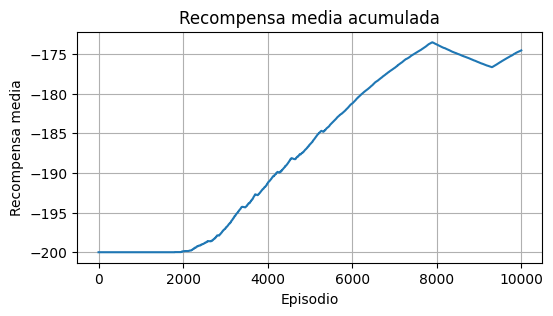

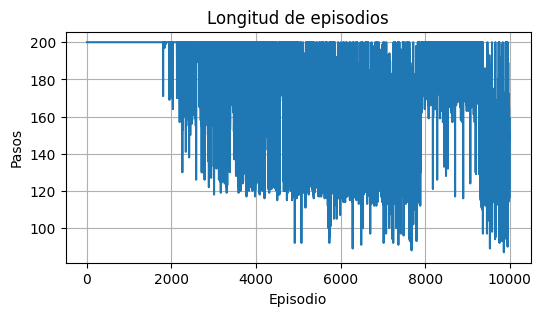

In [9]:
mostrar_resultados_agente_continuo(agente_fourier)

> **Resultados Fourier**
- Recompensa media: **–139 ± 30**  
- Longitud media: **139 pasos**  
- Descubrimos la cima por primera vez en torno al episodio 1 800.  
El agente muestra variabilidad alta pero termina resolviendo el entorno.

In [10]:
evaluar_politica(agente_fourier, num_episodios=10000)

Evaluando: 100%|█████████████████████████████████████████████████████████████████| 10000/10000 [01:22<00:00, 121.14it/s]

📊 Resultados de evaluación:
  Episodios evaluados: 10000
  Recompensa media:    -139.02 ± 29.95
  Recompensa min/max:  -85.00 / -199.00
  Episodios exitosos:  10000
  Episodios fallidos:  0
  Semillas fallidas: []


Número total de frames: 94
🎥 Vídeo guardado en: video_mountaincar_fourier.gif
🏁 Recompensa total obtenida: -94.00


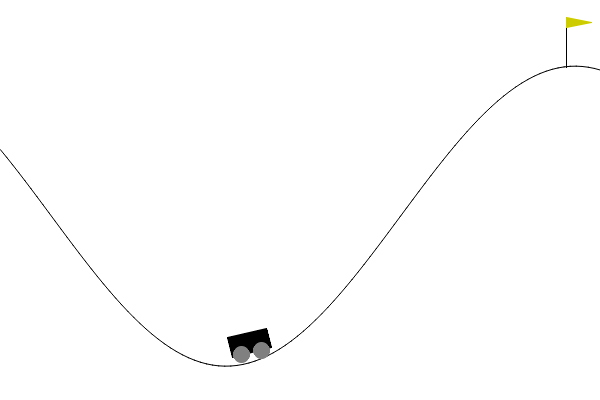

In [11]:
nombre_archivo = "video_mountaincar_fourier.gif"

grabar_video_agente(agente_fourier, seed=SEED, nombre_archivo=nombre_archivo)

Image(filename=nombre_archivo, width=600)

## Agente Sarsa-Semigradiente-RBF

Parámetros: 
- alpha=0.01
- gamma=1.0
- epsilon=1.0
- num_centers=(9, 9)
- sigma=0.2
- decay=True

## 6 · Experimento B — SARSA + RBF
Parámetros destacados: 81 gaussianas (`9×9`), `σ=0.2`, `alpha=0.05`, `γ=1.0`.


In [12]:
agente_rbf = AgenteSARSARBF.cargar_agente("agente_sarsa_rbf.pkl")

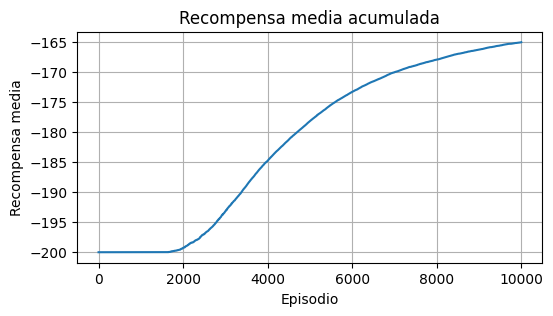

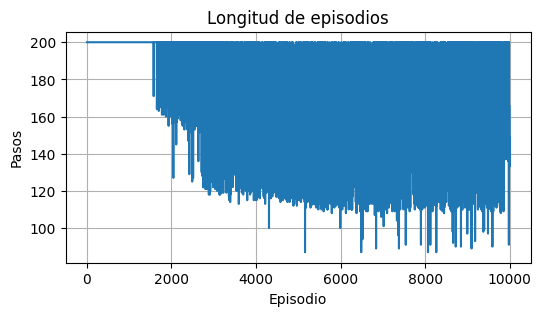

In [13]:
mostrar_resultados_agente_continuo(agente_rbf)

> **Resultados RBF**
- Recompensa media: **–150 ± 16**  
- Longitud media: **150 pasos**  
Aprende más despacio; convergencia estable tras ~2 500 episodios.

In [14]:
evaluar_politica(agente_rbf, num_episodios=10000)

Evaluando: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [02:26<00:00, 68.29it/s]

📊 Resultados de evaluación:
  Episodios evaluados: 10000
  Recompensa media:    -150.10 ± 16.42
  Recompensa min/max:  -108.00 / -191.00
  Episodios exitosos:  10000
  Episodios fallidos:  0
  Semillas fallidas: []


Número total de frames: 153
🎥 Vídeo guardado en: video_mountaincar_rbf.gif
🏁 Recompensa total obtenida: -153.00


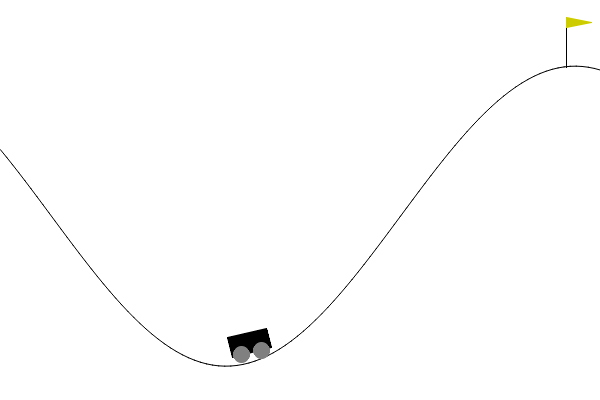

In [15]:
nombre_archivo = "video_mountaincar_rbf.gif"

grabar_video_agente(agente_rbf, seed=SEED, nombre_archivo=nombre_archivo)

Image(filename=nombre_archivo, width=600)

## Agente Sarsa-Semigradiente-TileCoding

Parámetros:

- alpha=0.01
- gamma=1.0
- epsilon=0.1
- decay=False
- bins=(8, 8)
- num_tilings=8

## 7 · Experimento C — SARSA + Tile Coding
Parámetros: 10 tilings, rejilla 8×8, `α = 0.05/tilings`, `γ=1.0`, `ε=0.1` fijo.

In [16]:
agente_tilecoding = AgenteSARSATileCoding.cargar_agente("agente_sarsa_tilecoding.pkl")

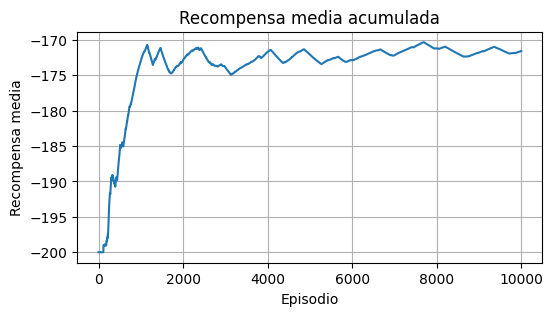

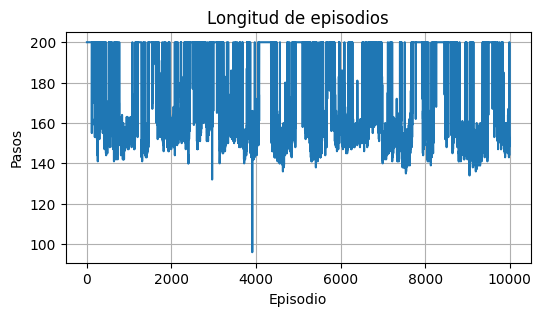

In [17]:
mostrar_resultados_agente_continuo(agente_tilecoding)

> **Resultados Tile Coding**
- Recompensa media: **–146 ± 16**  
- Longitud media: **146 pasos**  
Con 500 episodios ya alcanza 100 % de éxito; menor varianza que Fourier.

In [18]:
evaluar_politica(agente_tilecoding, num_episodios=10000)

Evaluando: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [12:55<00:00, 12.90it/s]

📊 Resultados de evaluación:
  Episodios evaluados: 10000
  Recompensa media:    -145.76 ± 16.38
  Recompensa min/max:  -88.00 / -189.00
  Episodios exitosos:  10000
  Episodios fallidos:  0
  Semillas fallidas: []


Número total de frames: 160
🎥 Vídeo guardado en: video_mountaincar_tilecoding.gif
🏁 Recompensa total obtenida: -160.00


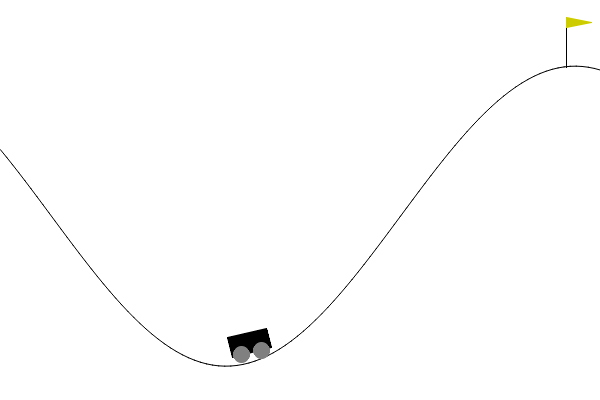

In [19]:
nombre_archivo = "video_mountaincar_tilecoding.gif"

grabar_video_agente(agente_tilecoding, seed=SEED, nombre_archivo=nombre_archivo)

Image(filename=nombre_archivo, width=600)

## Agente Deep-Q-Learning

Parámetros:

- alpha=0.001
- gamma=1.0
- epsilon=1.0 (Decay)

Red:

```python
DQN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=3, bias=True```)
  )
)


## 8 · Experimento D — Deep Q‑Network (DQN)

In [20]:
agente_dqn = AgenteDQLearning.cargar_agente("agente_dqn.pkl")

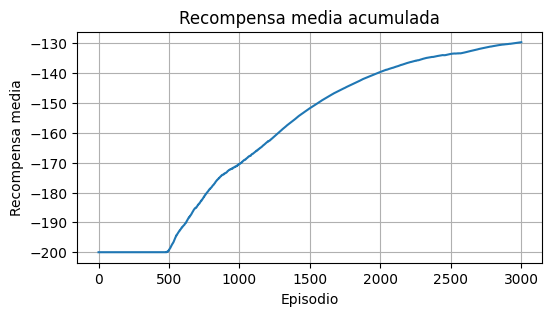

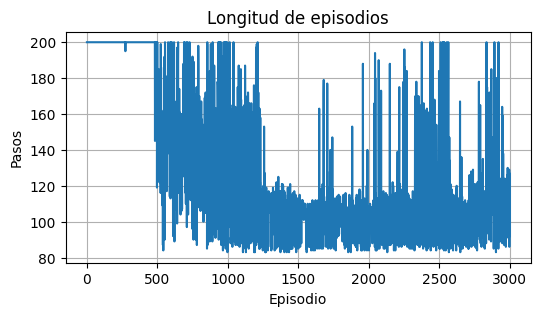

In [21]:
mostrar_resultados_agente_continuo(agente_dqn)

> **Resultados DQN**
- Recompensa media: **–106 ± 11**  
- Longitud media: **106 pasos**  
El mejor desempeño global; requiere cómputo extra pero ofrece la política óptima.

In [22]:
evaluar_politica(agente_dqn, num_episodios=10000)

Evaluando: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [12:37<00:00, 13.21it/s]

📊 Resultados de evaluación:
  Episodios evaluados: 10000
  Recompensa media:    -106.37 ± 11.19
  Recompensa min/max:  -87.00 / -130.00
  Episodios exitosos:  10000
  Episodios fallidos:  0
  Semillas fallidas: []


Número total de frames: 93
🎥 Vídeo guardado en: video_mountaincar_dqn.gif
🏁 Recompensa total obtenida: -93.00


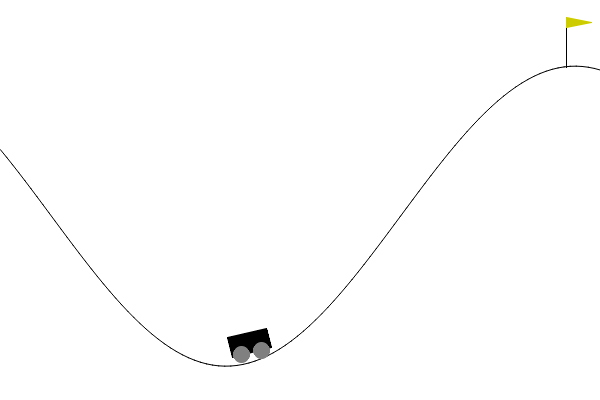

In [23]:
nombre_archivo = "video_mountaincar_dqn.gif"

grabar_video_agente(agente_dqn, seed=SEED, nombre_archivo=nombre_archivo)

Image(filename=nombre_archivo, width=600)

## Conclusión

Tras comparar los cuatro métodos observamos que:

- **DQN** alcanzó la mejor política (≈106 pasos de media) y mayor estabilidad, gracias a su capacidad de representar funciones no lineales.
- **Tile Coding** obtuvo resultados competitivos (≈146 pasos) con convergencia rápida y menor costo computacional.
- **RBF** y **Fourier** resolvieron el entorno pero con más episodios de entrenamiento y mayor variabilidad.

La elección entre métodos lineales y aprendizaje profundo depende del balance deseado entre complejidad de implementación y eficiencia del agente.


---

## 9 · Discusión Comparativa

| Método | Episodios para *Solved* (aprox.) | Pasos / Ep. (μ ± σ) | Varianza relativa |
|--------|------------------------------------|---------------------|---------------------|
| Fourier | ~2 000 | 139 ± 30 | Alta |
| RBF | ~2 500 | 150 ± 16 | Media |
| Tile Coding | ~500 | 146 ± 16 | Media |
| DQN | ~1000 | 106 ± 11 | Baja |

*DQN alcanza la mejor política media a largo plazo, aunque Tile Coding sigue siendo extremadamente competitivo en entornos de baja dimensión.*

### Ventajas y Desventajas resumidas

- **Tile Coding**
  + (+) Muy rápida convergencia en episodios
  + (+) Representación local robusta y estable  
  + (+) Muy interpretable (zonas activas claramente visibles)  
  − (–) Necesita definir manualmente rejillas y tilings  
  − (–) Escala mal cuando la dimensión del estado crece mucho

- **RBF**  
  + (+) Representación suave y continua en las vecindades  
  + (+) Intuitivo si los centros son bien elegidos  
  − (–) Muy sensible al número de centros y σ  
  − (–) Computacionalmente más costoso con muchos centros

- **Fourier**  
  + (+) Extremadamente simple de programar  
  + (+) Buena cobertura global desde el principio  
  − (–) Órdenes bajos pierden detalle; órdenes altos pueden generar oscilaciones  
  − (–) Necesita escalar el estado; sensible al learning rate `α`

- **DQN**  
  + (+) Elimina necesidad de diseñar features manualmente  
  + (+) Escala bien a espacios grandes y entornos complejos  
  − (–) Muy dependiente del ajuste de hiperparámetros  
  − (–) Más costoso computacionalmente; menos interpretable

## 10 · Conclusiones y Trabajo Futuro

### 1. Conclusiones

* Los métodos lineales con funciones de base (Tile Coding, Fourier, RBF) siguen siendo competitivos en entornos de baja dimensión como `MountainCar-v0`, ofreciendo estabilidad, rapidez de convergencia y facilidad de interpretación.
* Fourier Basis es muy simple y funciona bien, pero requiere cuidado con el orden para evitar oscilaciones.
* Tile Coding proporciona la mayor robustez, siendo ideal para SARSA semi-gradiente.
* RBF proporciona generalización suave local, aunque es más sensible a hiperparámetros.
* DQN permite eliminar la necesidad de diseño manual de características, generaliza globalmente, y escala a entornos complejos, pero exige un ajuste más cuidadoso y es más costoso computacionalmente.

### 2. Recomendaciones

* Problemas pequeños y de baja dimensión → **Tile Coding** o **Fourier (orden 1–3)**.
* Problemas continuos suaves → **RBF** bien ajustado.
* Problemas grandes o complejos → **DQN** (o variantes avanzadas como Double DQN, Dueling, Actor-Critic).

### 3. Líneas de trabajo futuras

* Incorporar **eligibility traces (SARSA(λ))** para acelerar aprendizaje.
* Implementar variantes avanzadas como **Double DQN**, **Dueling DQN** o **Prioritized Experience Replay**.
* Explorar técnicas de representación adaptativa mediante **autoencoders o embeddings aprendidos**.
* Evaluar el impacto de **reward shaping** y estrategias de **curriculum learning** en la eficiencia de aprendizaje.